# ARIMA, Seasonal ARIMA 실습

## 1. 모듈 불러오기

In [97]:
!pip install pandas_datareader

In [232]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

import itertools

## 2. 데이터 불러오기

In [233]:
data = pd.read_csv('/content/drive/MyDrive/2021/ARIMA/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [234]:
data = data.rename(columns = {'Month': 'month', '#Passengers': 'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## 3. Box-Jenkins ARIMA Procedure

### 3.1 Data Preprocessing

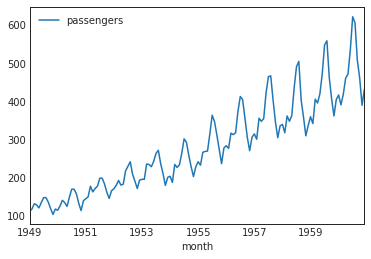

In [235]:
# Raw data plot
fig = data.plot()

Observed : observed data <br/>
Trend : The estimated trend component <br/>
Seasonal : The estimated seasonal component <br/>
resid : The estimated residuals

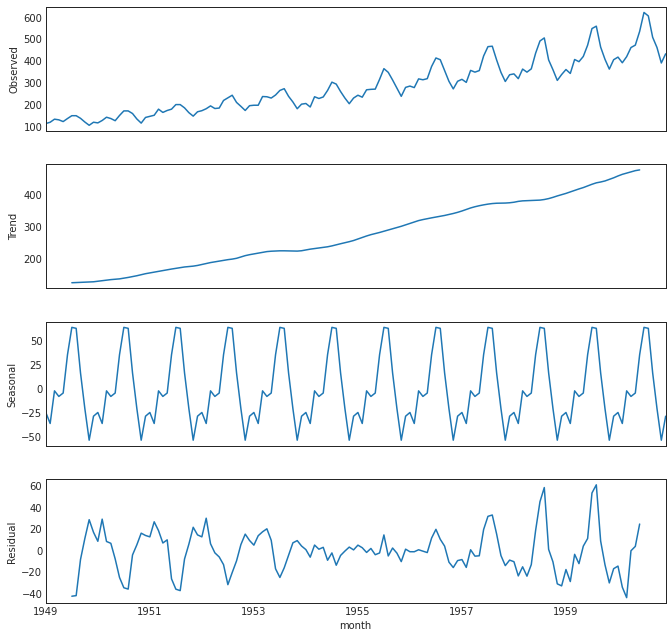

In [236]:
# Seasonal Decomposition plot : Seasonal decomposition using moving averages

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(data['passengers'], model = 'additive')
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

### 3.2 Identify Model to be Tentatively Entertained

In [237]:
# train : test = 8 : 2
train_data, test_data = train_test_split(data, test_size = 0.2, shuffle = False)

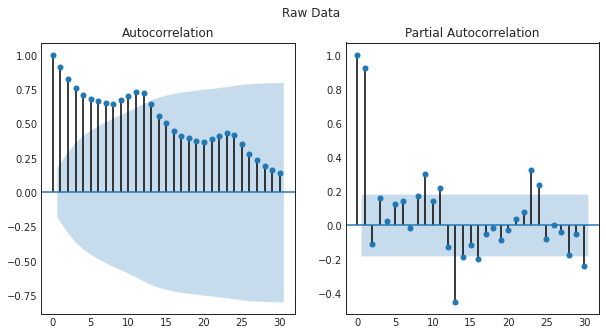

In [238]:
# ACF, PACF Plot

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags = 30, ax = ax[0])  # Autocorrelation
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags = 30, ax = ax[1]); # Partial Autocorrelation

**Differencing**

현 시점 데이터에서 d 시점 이전 데이터를 뺀 것

원본 데이터가 nonstationary하면 differencing이 필요하다.

-------------
1차 차분: $Y_t = X_t - X_{t-1} = \triangledown X_t$

2차 차분: $Y_t^{(2)} = X_t - X_{t-2} = \triangledown^{(2)} X_t $

3차 차분: $Y_t^{(d)} = X_t - X_{t-d} = \triangledown^{(d)} X_t $


In [239]:
# differencign

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()  # 차분을 하면 끝에 길이가 맞지 않아 결측치가 생김. 이 것을 처리 해줘야 함.
print('----- Raw data -----')
print(train_data)
print('--- Differenced data ---')
print(diff_train_data)

----- Raw data -----
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
--- Differenced data ---
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


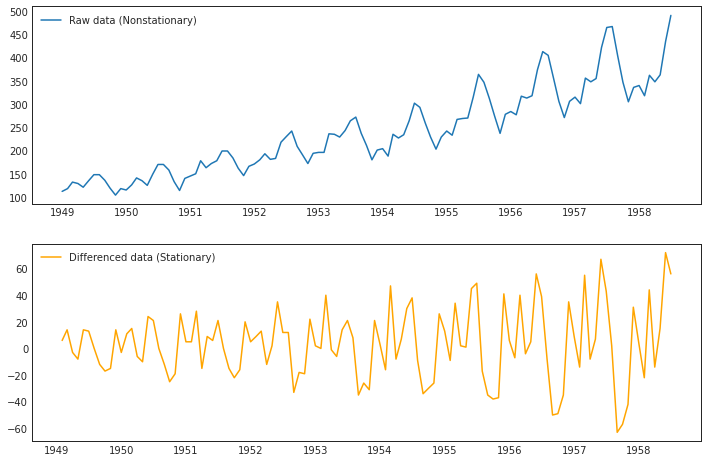

In [240]:
# differenced data plot

plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # first difference ( t - (t - 1))
plt.legend(['Differenced data (Stationary)'])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


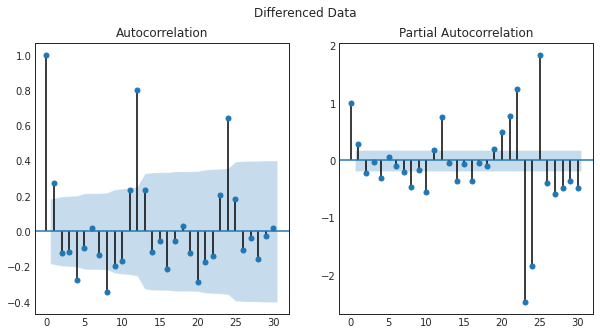

In [241]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax = ax[1]);

autocorrelation이 점점 줄어드는 것을 볼 수 있다.

여기서 Graphical Method를 사용하여야 함. 

making inferences from the patterns of the sample autocorrelation and partial autocorrelation functions of the series

|  <center>Model</center> |  <center>ACF</center> |  <center>Partial ACF</center> |
|:--------|:--------:|--------:|
|**MA(q)** | <center>Cut off after lag q <br/>(q 시차 이후 0으로 절단) </center> |*Die out <br/> (지수적으로 감소,<br/> 소멸하는 sine함수 형태)* |
|**AR(p)** | <center>Die out<br/>(지수적으로 감소,<br/> 소멸하는 sine함수 형태) </center> |*Cut off after lag p <br/> (p 시차 이후 0으로 절단)* |
|**ARMA(p, q)** | <center>Die out<br/> (시차 q-p 이후 부터 소멸) </center> |*Die out <br/> (시차 q-p 이후 부터 소멸)* |

### 3.3 Estimate Parameters

In [242]:
# ARIMA model fitting
# (p, d, q) -> p : the # of AR parameters, d: # of differences, q : # of MA parameters

model = ARIMA(train_data.values, order = (1, 1, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Mon, 28 Jun 2021   AIC                           1069.440
Time:                        12:42:10   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.294      -3.012      10.036
ar.L1.D.y      0.2803      0.091      3.077      0.003       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

### 3.4.1 Diagnosis Check - ARIMA

In [243]:
# Parameter search

print('Examples of parameter combinations for Seasonal ARIMA')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))  # 효율적인 반복을 위한 함수!

aic = []
for i in pdq:
  model = ARIMA(train_data.values, order = (i))
  model_fit = model.fit()
  print(f'ARIMA: {i} >> AIC : {round(model_fit.aic, 2)}')
  aic.append(round(model_fit.aic, 2))


Examples of parameter combinations for Seasonal ARIMA
ARIMA: (0, 1, 0) >> AIC : 1076.52
ARIMA: (0, 1, 1) >> AIC : 1064.62
ARIMA: (0, 1, 2) >> AIC : 1061.08
ARIMA: (1, 1, 0) >> AIC : 1069.44
ARIMA: (1, 1, 1) >> AIC : 1058.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  


ARIMA: (1, 1, 2) >> AIC : 1046.05
ARIMA: (2, 1, 0) >> AIC : 1066.2
ARIMA: (2, 1, 1) >> AIC : 1045.66
ARIMA: (2, 1, 2) >> AIC : 1047.19


가장 낮은 AIC score의 parameter 값을 취함

In [244]:
# search optimal parameters

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [245]:
model_opt = ARIMA(train_data.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Mon, 28 Jun 2021   AIC                           1045.660
Time:                        12:42:13   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.163     15.754      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4540           -0.1046
AR.2            1.1512           +0.8882j            1.4540            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

### 3.5.1 use Model to Forcase - ARIMA

In [253]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [254]:
print(r2)

0.22444481740638111


In [255]:
print(predict_index)
print(predicted_value)

[Timestamp('1958-08-01 00:00:00'), Timestamp('1958-09-01 00:00:00'), Timestamp('1958-10-01 00:00:00'), Timestamp('1958-11-01 00:00:00'), Timestamp('1958-12-01 00:00:00'), Timestamp('1959-01-01 00:00:00'), Timestamp('1959-02-01 00:00:00'), Timestamp('1959-03-01 00:00:00'), Timestamp('1959-04-01 00:00:00'), Timestamp('1959-05-01 00:00:00'), Timestamp('1959-06-01 00:00:00'), Timestamp('1959-07-01 00:00:00'), Timestamp('1959-08-01 00:00:00'), Timestamp('1959-09-01 00:00:00'), Timestamp('1959-10-01 00:00:00'), Timestamp('1959-11-01 00:00:00'), Timestamp('1959-12-01 00:00:00'), Timestamp('1960-01-01 00:00:00'), Timestamp('1960-02-01 00:00:00'), Timestamp('1960-03-01 00:00:00'), Timestamp('1960-04-01 00:00:00'), Timestamp('1960-05-01 00:00:00'), Timestamp('1960-06-01 00:00:00'), Timestamp('1960-07-01 00:00:00'), Timestamp('1960-08-01 00:00:00'), Timestamp('1960-09-01 00:00:00'), Timestamp('1960-10-01 00:00:00'), Timestamp('1960-11-01 00:00:00'), Timestamp('1960-12-01 00:00:00')]
[478.47688305

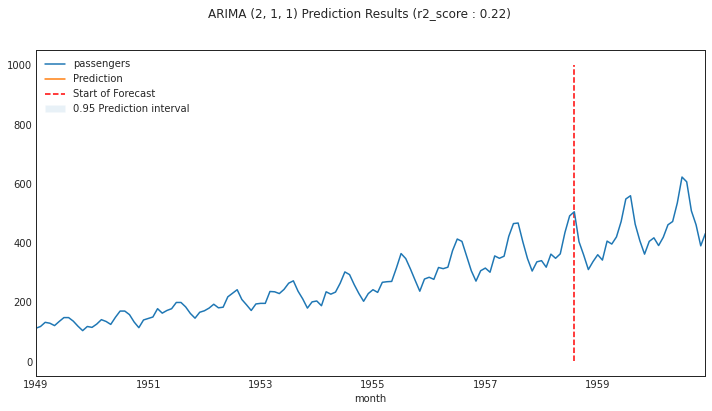

In [259]:
fig, ax = plt.subplots(figsize = (12, 6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 1000, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax.plot(predicted_value, linestyle = '-', label = 'Prediction')
ax.fill_between(predicted_lb, predicted_ub, alpha = 0.1, label = '0.95 Prediction interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Results (r2_score : {round(r2, 2)})')
plt.show()

### 3.4.2 Diagnosis Check - SARIMA

In [87]:
# Parameter Search

print('Examples of parameter combinations for Seasonal ARIMA')
p = range(0, 3)
d = range(1, 2)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # 12달 마다 패턴이 있을 것으로 생각하여 12를 넣음

aic = []
params = []
for i in pdq:
  for j in seasonal_pdq:
    try:
      model = SARIMAX(train_data.values, order = (i), seasonal_order = (j))
      model_fit = model.fit()
      print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic, 2)}')
      aic.append(round(model_fit.aic, 2))
      params.append((i, j))
    except:
      continue

Examples of parameter combinations for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : 757.83
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : 756.99
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : 758.83
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : 756.96
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : 758.92
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : 754.42
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : 758.87
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : 760.73


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : 754.91
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : 756.01
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : 756.38
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : 757.65
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : 756.17
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : 758.11


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : 751.73
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : 757.99
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : 753.78
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : 757.78
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC : 758.04
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC : 759.28
SARIMA : (0, 1, 2)(1, 1, 0, 12) >> AIC : 757.81
SARIMA : (0, 1, 2)(1, 1, 1, 12) >> AIC : 759.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (0, 1, 2)(1, 1, 2, 12) >> AIC : 753.5
SARIMA : (0, 1, 2)(2, 1, 0, 12) >> AIC : 759.64
SARIMA : (0, 1, 2)(2, 1, 1, 12) >> AIC : 755.48


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (0, 1, 2)(2, 1, 2, 12) >> AIC : 763.54
SARIMA : (1, 1, 0)(0, 1, 0, 12) >> AIC : 755.5
SARIMA : (1, 1, 0)(0, 1, 1, 12) >> AIC : 755.98
SARIMA : (1, 1, 0)(0, 1, 2, 12) >> AIC : 757.1
SARIMA : (1, 1, 0)(1, 1, 0, 12) >> AIC : 755.75
SARIMA : (1, 1, 0)(1, 1, 1, 12) >> AIC : 757.65
SARIMA : (1, 1, 0)(1, 1, 2, 12) >> AIC : 751.15
SARIMA : (1, 1, 0)(2, 1, 0, 12) >> AIC : 757.45
SARIMA : (1, 1, 0)(2, 1, 1, 12) >> AIC : 752.98
SARIMA : (1, 1, 0)(2, 1, 2, 12) >> AIC : 759.86
SARIMA : (1, 1, 1)(0, 1, 0, 12) >> AIC : 756.02
SARIMA : (1, 1, 1)(0, 1, 1, 12) >> AIC : 756.63
SARIMA : (1, 1, 1)(0, 1, 2, 12) >> AIC : 757.75
SARIMA : (1, 1, 1)(1, 1, 0, 12) >> AIC : 756.41
SARIMA : (1, 1, 1)(1, 1, 1, 12) >> AIC : 758.26
SARIMA : (1, 1, 1)(1, 1, 2, 12) >> AIC : 752.53
SARIMA : (1, 1, 1)(2, 1, 0, 12) >> AIC : 758.03
SARIMA : (1, 1, 1)(2, 1, 1, 12) >> AIC : 754.16
SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC : 757.92
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC : 758.44
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC : 7

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC : 754.53
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC : 759.92


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC : 756.16


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : 763.4
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : 756.77
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : 757.23
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : 758.31
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : 756.98
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : 758.86
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : 752.77
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : 758.65
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : 754.5


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC : 762.44
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : 757.98


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  params_exog = []
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.k_ar > 0 and


SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : 758.54
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : 759.69
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : 758.31
SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : 760.18


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : 754.54
SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : 759.98


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : 756.16
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : 755.2
SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : 755.99
SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : 759.77
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : 755.82
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : 757.71
SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : 752.34
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : 757.56
SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : 753.96


In [88]:
# search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 0), (1, 1, 2, 12)), 751.15)]

앞의 ARIMA 보다 AIC score가 훨씬 낮은 것을 확인할 수 있다.

In [89]:
model_opt = SARIMAX(train_data.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, 2, 12)   Log Likelihood                -370.574
Date:                            Mon, 28 Jun 2021   AIC                            751.148
Time:                                    11:36:49   BIC                            764.273
Sample:                                         0   HQIC                           756.463
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2365      0.093     -2.553      0.011      -0.418      -0.055
ar.S.L12       0.9985      0.192      5.213      0.000       0.623       1.374
ma.S.L12      -1.3686      2.457     -0.557      0.577      -6.184       3.447
ma.S.L24       0.3932      0.873      0.450      0.652      -1.318       2.104
sigma2        69.9140    159.108      0.439      0.660    -241.931     381.759
===================================================================================
Ljung-Box (Q):                       39.85   Jarque-Bera (JB):                 2.76
Prob(Q):                              0.48   Prob(JB):                         0.25
Heteroskedasticity (H):               1.10   Skew:                             0.38
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.2 Use Model to Forcast - SARIMA

In [91]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

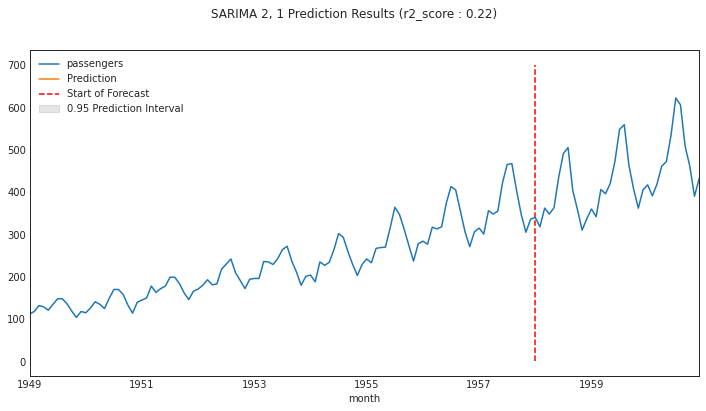

In [180]:
fig, ax = plt.subplots(figsize = (12, 6))
data.plot(ax = ax);
ax.vlines('1958-01-01', 0, 700, linestyle = '--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2_score : {round(r2, 2)})')
plt.show()

### DIagnosis Check - auto_arima

In [181]:
# parameter search

auto_arima_model = auto_arima(train_data, start_p = 1, start_q = 1,
                              max_p = 3, max_q = 3, m = 12, seasonal = True, 
                              d = 1, D = 1, max_P = 3, max_Q = 3,
                              trace = True, error_action = 'ignore',
                              suppress_warnings = True, stepwise = False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.96 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.33 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.30 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=1.50 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=3.97 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.87 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=6.98 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=7.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             

In [182]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(0, 1, 3)x(0, 1, 0, 12)   Log Likelihood                -372.468
Date:                            Mon, 28 Jun 2021   AIC                            752.936
Time:                                    12:10:03   BIC                            763.436
Sample:                                         0   HQIC                           757.188
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2214      0.095     -2.330      0.020      -0.408      -0.035
ma.L2          0.1246      0.109      1.146      0.252      -0.088       0.338
ma.L3         -0.2929      0.103     -2.836      0.005      -0.495      -0.090
sigma2        86.6902     13.294      6.521      0.000      60.635     112.746
===================================================================================
Ljung-Box (Q):                       33.71   Jarque-Bera (JB):                 2.79
Prob(Q):                              0.75   Prob(JB):                         0.25
Heteroskedasticity (H):               1.12   Skew:                             0.37
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.5.3 Use Model to Forecast - auto_arima

In [183]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

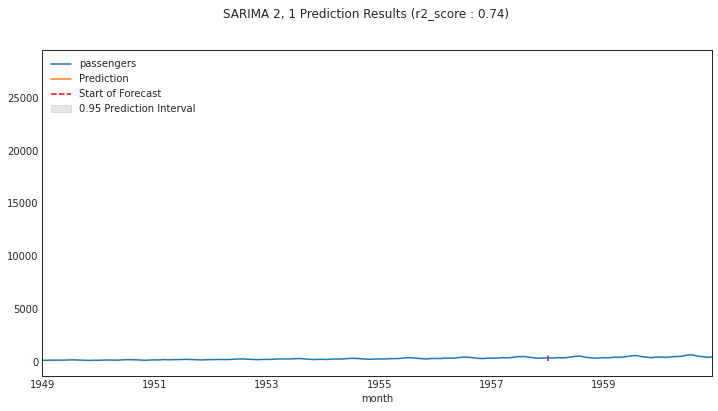

In [231]:
fig, ax = plt.subplots(figsize = (12, 6))
data.plot(ax = ax);
ax.vlines('1958-01-01', 0, 700, linestyle = '--', color = 'r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend(loc = 'upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]} Prediction Results (r2_score : {round(r2, 2)})')
plt.show()

##4. Case study : 주가 예측

In [264]:
# 기업명을 넣었을 때 종목 코드가 산출 되도록 하는 함수
def get_code(df, name):
  code = df.query("name == '{}'".format(name))['code'].to_string(index = False)
  code = code.strip()
  return code

크롤링

In [265]:
code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header = 0)[0]
code_data # 2380 rows  x  9 columns

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DRB동일,4840,고무제품 제조업,"고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매",1976-05-21,12월,류영식,http://drbworld.com,부산광역시
1,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
2,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
3,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시
4,KEC,92220,반도체 제조업,반도체 제조,2006-10-16,12월,박남규 김학남,http://www.kec.co.kr,서울특별시
...,...,...,...,...,...,...,...,...,...
2446,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도
2447,툴젠,199800,자연과학 및 공학 연구개발업,"유전자가위 (유전체 교정 도구) 및 이를 이용한 유전자세포치료제, 고부가가치 가축,...",2014-06-25,12월,"김영호, 이병화(각자 대표이사)",http://www.toolgen.com,서울특별시
2448,플럼라인생명과학,222670,자연과학 및 공학 연구개발업,"강아지암치료제,돼지DNA테라피",2015-07-28,12월,김앤토니경태,http://www.plsdna.com,서울특별시
2449,한국미라클피플사,331660,기타 화학제품 제조업,"은나노스텝, 닥터오렌지 등",2019-10-28,12월,이호경,http://www.kmpc.co.kr,경기도


In [266]:
code_data = code_data[['회사명', '종목코드']]
code_data = code_data.rename(columns = {'회사명': 'name', '종목코드': 'code'})
code_data.code = code_data.code.map('{:06d}'.format)

갖고 있는 종목인 포스코 인터내셔널 예측해보겠다.

In [267]:
stock_code = get_code(code_data, '포스코인터내셔널')
stock_code = stock_code + '.KS'
stock_data = pdr.get_data_yahoo(stock_code)

High : 장 중 제일 높았던 주가 (고가)
Low : 장 중 제일 낮았덙 주가 (저가)
Open : 장 시작 때 주가 (시가)
Close : 장 닫을 때 주가 (종가)
Volume : 주식 거래량
Adj Close : 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

In [268]:

stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-29,24800.0,23900.0,24450.0,24500.0,162384.0,20789.394531
2016-06-30,25000.0,24550.0,24800.0,25000.0,194651.0,21213.667969
2016-07-01,25300.0,24000.0,25000.0,24000.0,313700.0,20365.121094
2016-07-04,24350.0,23750.0,24200.0,24150.0,181629.0,20492.404297
2016-07-05,24300.0,23750.0,24100.0,23900.0,129252.0,20280.267578
...,...,...,...,...,...,...
2021-06-22,23600.0,21750.0,21950.0,23450.0,3373068.0,23450.000000
2021-06-23,23550.0,22700.0,23300.0,23100.0,1505634.0,23100.000000
2021-06-24,23100.0,22500.0,23050.0,22800.0,832259.0,22800.000000


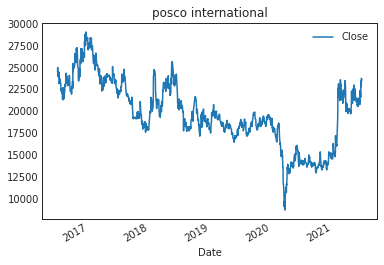

In [269]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()
plt.title("posco international")
plt.show()

In [270]:
from sklearn.model_selection import train_test_split
stock_data_train, stock_data_test = train_test_split(stock_data, test_size = 0.05, shuffle = False)

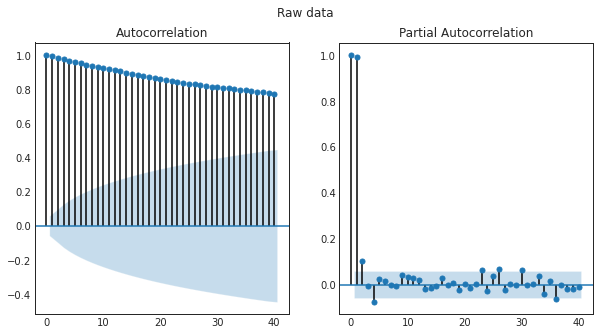

In [271]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Raw data')
sm.graphics.tsa.plot_acf(stock_data_train.values.squeeze(), lags = 40, ax = ax[0])  # auto-correlation
sm.graphics.tsa.plot_pacf(stock_data_train.values.squeeze(), lags = 40, ax = ax[1]); # partial auto-correlation

In [272]:
diff_stock_data_train = stock_data_train.copy()
diff_stock_data_train = diff_stock_data_train['Close'].diff() # differencing
diff_stock_data_train = diff_stock_data_train.dropna()        # diffenencing 시 맨 끝에 생기는 결측치 해결
print('----- Raw data -----')
print(stock_data_train)
print('--- Differenced data ---')
print(diff_stock_data_train)

----- Raw data -----
              Close
Date               
2016-06-29  24500.0
2016-06-30  25000.0
2016-07-01  24000.0
2016-07-04  24150.0
2016-07-05  23900.0
...             ...
2021-03-24  19950.0
2021-03-25  20950.0
2021-03-26  20450.0
2021-03-29  20000.0
2021-03-30  20850.0

[1160 rows x 1 columns]
--- Differenced data ---
Date
2016-06-30     500.0
2016-07-01   -1000.0
2016-07-04     150.0
2016-07-05    -250.0
2016-07-06     -50.0
               ...  
2021-03-24    -550.0
2021-03-25    1000.0
2021-03-26    -500.0
2021-03-29    -450.0
2021-03-30     850.0
Name: Close, Length: 1159, dtype: float64


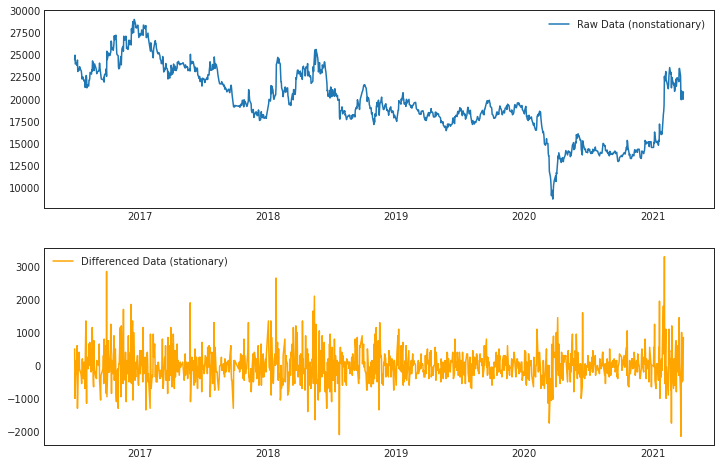

In [273]:
# differenced data plot

plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(stock_data_train['Close'])
plt.legend(['Raw Data (nonstationary)'])
plt.subplot(212)
plt.plot(diff_stock_data_train, 'orange') # first difference
plt.legend(['Differenced Data (stationary)'])
plt.show()

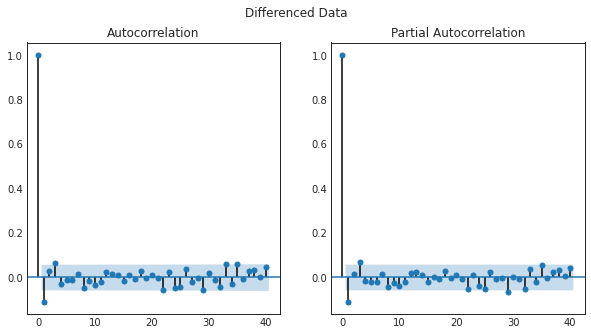

In [274]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_stock_data_train.values.squeeze(), lags = 40, ax = ax[1]);

파라미터 선정에 힘들 것 같음 . auto-arima 사용 해야겠음

주식 데이터는 seasonal 파악이 어려워 SARIMA가 아닌 ARIMA 모델 채택

In [275]:
# parameter search

auto_arima_model = auto_arima(stock_data_train, start_p = 1, start_q = 1, 
                              max_p = 3, max_q = 3, seasonal = False,
                              d = 1, trace = True, 
                              error_action = 'ignore', suppress_warnings = True,
                              stepwise = False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17714.009, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17704.688, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17706.164, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=17704.107, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17704.468, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17706.465, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17707.305, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17705.026, Time=1.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17706.468, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17708.071, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17704.680, Time=1.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17706.368, Time=1.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17703.374, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17704.988, Time=1.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17706.390, Time=0.72

In [276]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1160
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -8846.687
Date:                Mon, 28 Jun 2021   AIC                          17703.374
Time:                        12:46:33   BIC                          17728.650
Sample:                             0   HQIC                         17712.911
                               - 1160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.9344     15.391     -0.191      0.849     -33.100      27.231
ar.L1         -0.0968      0.023     -4.240      0.000      -0.142      -0.052
ar.L2          0.0069      0.021      0.327      0.744      -0.035       0.048
ar.L3          0.0638      0.023      2.819      0.005       0.019       0.108
sigma2      2.486e+05   6082.865     40.870      0.000    2.37e+05    2.61e+05
===================================================================================
Ljung-Box (Q):                       38.98   Jarque-Bera (JB):              1114.42
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.70
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [277]:
prediction = auto_arima_model.predict(len(stock_data_test), return_conf_int = True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 0]
predicted_lb = prediction[1][:, 1]
predict_index = list(stock_data_test.index)
predict_index[0]

Timestamp('2021-03-31 00:00:00')

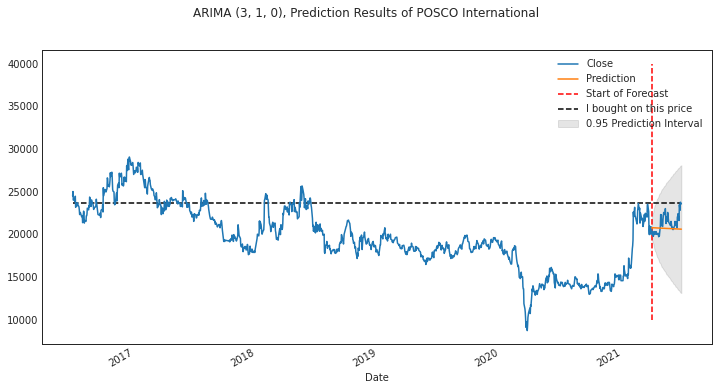

In [280]:
fig, ax = plt.subplots(figsize = (12, 6))
stock_data.plot(ax = ax);
ax.vlines('2021-03-31', 10000, 40000, linestyle = '--', color = 'r', label = 'Start of Forecast')
ax.hlines(23600, '2016-06-29', '2021-06-28', linestyles = '--', label = 'I bought on this price')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.legend()
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results of POSCO International')
plt.show()

ARIMA 모델은 parametric 모델 방식

패턴이 어느 정도 뚜렷한 데이터에는 ARIMA 모델의 성능이 좋게 나오지만

복잡한 데이터에서는 딥러닝 계열의 성능이 훨씬 뛰어나다.